### Short Term Memory


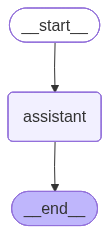

In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage,SystemMessage
from IPython.display import Image, display


llm = ChatOpenAI(model = "gpt-4o-mini")

def assistant(state:MessagesState):
    """ Eres un asisten de mensajes"""
    return {"messages": [llm.invoke(state["messages"])]}

graph = StateGraph(MessagesState)
graph.add_node("assistant", assistant)
graph.add_edge(START, "assistant")
graph.add_edge("assistant",END)

builder = graph.compile()

display(Image(builder.get_graph(xray=True).draw_mermaid_png()))


In [9]:
messages= [
    HumanMessage(content="Hola mi nombre es David")
]

response = builder.invoke({"messages":messages})
for m in response["messages"]:
    m.pretty_print()

messages = [
    HumanMessage(content="Remember my name?")
]

messages = builder.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hola mi nombre es David
================================== Ai Message ==================================

¡Hola, David! ¿Cómo puedo ayudarte hoy?
================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don’t have the capability to remember personal information or previous interactions. But I’m here to help you with anything you need right now! What can I assist you with?


``` MemorySaver ``` es un checkpointer que guarda el estado de la conversación después de cada invocación del agente. Esto permite que el agente "recuerde" el contexto de conversaciones anteriores.



In [11]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = graph.compile(checkpointer = memory)

Cuando trabajamos con memory, necesitamos especificar un ```thread_id``` en la configuración de cada invocación del agente. Esto permite que el agente mantenga conversaciones separadas y recuerde el contexto de cada una.

In [12]:
config = {"configurable": {"thread_id": "conversation_1"}}
# Cada thread_id es una conversación separada
messages = [
    HumanMessage(content="Hola mi nombre es David")
]

response = graph_memory.invoke({"messages":messages},config)
for m in response['messages']:
    m.pretty_print()

messages = [
    HumanMessage(content="Cual es mi nombre")
]

response = graph_memory.invoke({"messages":messages},config)
for m in response['messages']:
    m.pretty_print()



================================ Human Message =================================

Hola mi nombre es David
================================== Ai Message ==================================

¡Hola, David! ¿Cómo estás? ¿En qué puedo ayudarte hoy?
================================ Human Message =================================

Hola mi nombre es David
================================== Ai Message ==================================

¡Hola, David! ¿Cómo estás? ¿En qué puedo ayudarte hoy?
================================ Human Message =================================

Cual es mi nombre
================================== Ai Message ==================================

Tu nombre es David. ¿Hay algo más en lo que te gustaría hablar o preguntar?


### Adding a summary to the state
El problema con esto es que los modelos de lenguaje tienen un límite en la cantidad de tokens que pueden procesar en una sola solicitud. Si la conversación es muy larga, puede exceder este límite y causar errores.
Podemos extender el estado de la conversación para incluir un resumen de los mensajes anteriores. Esto es útil para mantener el contexto sin exceder los límites de tokens del modelo.


In [14]:
from langgraph.graph import MessagesState
 
class State(MessagesState):
    summary: str #Almacen resumen de la conversacion


In [19]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from typing_extensions import Literal

# 🧠 FUNCIÓN 1: NODO PRINCIPAL DEL LLM (con contexto inteligente)
def call_model(state: State):
    """
    🎯 PROPÓSITO: Nodo principal que llama al LLM con contexto optimizado
    
    ✅ LO QUE HACE:
    - Si hay resumen → Lo incluye como SystemMessage para dar contexto
    - Si no hay resumen → Usa solo los mensajes actuales
    - Mantiene la conversación eficiente en tokens
    
    🔧 CUÁNDO SE USA: En cada interacción del usuario con el agente
    """
    
    # Obtener el resumen si existe
    summary = state.get("summary")
    
    if summary:
        # ✅ CLAVE: Agregar resumen como contexto del sistema
        system_message = f"Summary of conversation earlier: {summary}"
        # 🔧 FIX: Debe ser SystemMessage(content=...), no SystemMessage[...]
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        # Primera conversación o pocas mensajes → usar mensajes directos
        messages = state["messages"]

    response = llm.invoke(messages)
    # 🔧 FIX: Debe retornar el response, no solo invocarlo
    return {"messages": [response]}


# 📝 FUNCIÓN 2: CREADOR DE RESÚMENES (limpieza de memoria)
def summarize_conversation(state: State):
    """
    🎯 PROPÓSITO: Crear/actualizar resumen y limpiar mensajes antiguos
    
    ✅ LO QUE HACE:
    - Resume la conversación hasta el momento
    - Si ya hay resumen → Lo extiende con nueva información
    - Si no hay resumen → Crea uno desde cero
    - LIMPIA mensajes antiguos para ahorrar tokens
    
    🔧 CUÁNDO SE USA: Cuando hay demasiados mensajes (>20 en tu caso)
    """
    
    # Obtener resumen existente (si lo hay)
    summary = state.get("summary", "")
    
    # Crear prompt de summarización inteligente
    if summary:
        # 📄 Ya existe resumen → EXTENDER con nueva información
        summary_messages = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above."
        )
    else:
        # 📄 Primera vez → CREAR resumen completo
        summary_messages = "Create a summary of the conversation above:"

    # Agregar prompt al historial para que el LLM genere el resumen
    messages = state["messages"] + [HumanMessage(content=summary_messages)]
    response = llm.invoke(messages)

    # 🗑️ LIMPIEZA CRÍTICA: Eliminar mensajes antiguos, mantener solo los 2 últimos
    # 🔧 FIX: Debe ser [:-2] (todos menos los 2 últimos), no [:2] (solo los primeros 2)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {
        "summary": response.content,  # ✅ Nuevo resumen actualizado
        "messages": delete_messages   # ✅ Eliminar mensajes antiguos
    }


# 🤔 FUNCIÓN 3: DECISOR DEL FLUJO (controlador de lógica)
def should_continue(state: State) -> Literal["summarize_conversation", "END"]:
    """
    🎯 PROPÓSITO: Decidir si continuar conversando o activar summarización
    
    ✅ LO QUE HACE:
    - Cuenta mensajes en la conversación actual
    - Si >20 mensajes → Activa summarización (evita overflow de tokens)
    - Si ≤20 mensajes → Termina normalmente
    
    🔧 CUÁNDO SE USA: Después de cada respuesta del LLM (conditional_edges)
    
    💡 IMPORTANCIA: Previene que las conversaciones largas colapsen por límites de tokens
    """
    
    messages = state["messages"]

    # 📊 REGLA DE NEGOCIO: Límite de 20 mensajes antes de summarizar
    if len(messages) > 6:
        return "summarize_conversation"  # ← Ruta hacia función 2
    
    return "__end__"  # ← Termina la conversación



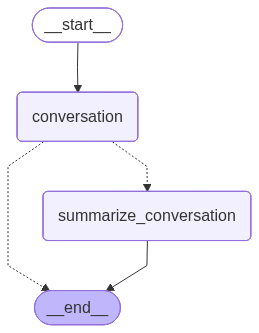

In [20]:
from IPython.display import Image, display 
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START ,END
llm  = ChatOpenAI(model="gpt-4o-mini")

#nodos
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

#flujo
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation", 
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "__end__": END
    }
)
workflow.add_edge("summarize_conversation", END)

#memoria
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [26]:
config = {"configurable": {"thread_id": "test_fix"}}
text_messages = {
  "Hola Soy david? Como estas?",
  "Vivo en Jujuy. Tengo 40 años",
  "Trabajo en tech ponele jeje..",
  "Me gusta aprender pero no me enfoco mucho",
  "No viajo mucho this is the true"
}

for i, msg in enumerate(text_messages):
    print(f"\n Enviando mensaje {i}:{msg}")
    result = graph.invoke(
        { "messages": [HumanMessage(content=msg)]} , config=config
    )
    print(f"🤖 Respuesta: {result['messages'][-1].content[:80]}...")
    state= graph.get_state(config)
    messages_count = len(state.values.get('messages', []))
    has_summary = bool(state.values.get('summary'))
    resumen = state.values.get('summary')
    print(f"Estado {messages_count} mensajes. Resumen {has_summary}")
    print(f"Texto resumen {resumen}")
    print("\n---------------")



 Enviando mensaje 0:Trabajo en tech ponele jeje..
🤖 Respuesta: ¡Genial! Trabajar en tech ofrece muchas oportunidades para aprender y crecer, es...
Estado 2 mensajes. Resumen True
Texto resumen In the ongoing conversation, David, who works in tech and resides in Jujuy, shares his enjoyment of learning despite having difficulty focusing on specific topics. The assistant encourages him to set small learning goals to manage his varied interests more effectively. David introduces himself and checks in on the assistant's well-being, reinforcing a friendly and engaging atmosphere.

He expresses a fondness for Jujuy, highlighting its beautiful landscapes and rich culture, while acknowledging that he doesn't travel much, which suggests a desire to explore and connect more deeply with his local surroundings. David's curiosity about learning remains evident, as he seeks ways to make it more engaging and relevant to his life.

The conversation reflects his interest in personal development alongsi